<a href="https://colab.research.google.com/github/gabrielvinicios02/ExperimentsMultivariate/blob/main/Bidirectional_LSTM_multivariate_horizon_style.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px # to plot the time series plot
from sklearn import metrics # for the evalution
from sklearn.preprocessing import LabelEncoder,MinMaxScaler

import tensorflow as tf

In [2]:
data = pd.read_csv('../content/sample_data/metro data.csv')
data

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,02-10-2012 09:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,02-10-2012 10:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,02-10-2012 11:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,02-10-2012 12:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,02-10-2012 13:00,4918
...,...,...,...,...,...,...,...,...,...
48199,None,283.45,0.0,0.0,75,Clouds,broken clouds,30-09-2018 19:00,3543
48200,None,282.76,0.0,0.0,90,Clouds,overcast clouds,30-09-2018 20:00,2781
48201,None,282.73,0.0,0.0,90,Thunderstorm,proximity thunderstorm,30-09-2018 21:00,2159
48202,None,282.09,0.0,0.0,90,Clouds,overcast clouds,30-09-2018 22:00,1450


In [3]:
data.holiday.unique()

array(['None', 'Columbus Day', 'Veterans Day', 'Thanksgiving Day',
       'Christmas Day', 'New Years Day', 'Washingtons Birthday',
       'Memorial Day', 'Independence Day', 'State Fair', 'Labor Day',
       'Martin Luther King Jr Day'], dtype=object)

In [4]:
plt.figure(figsize=(16,9))
fig = px.line(data, x=data.date_time, y='traffic_volume', title='traffic_volume with slider')
fig.update_xaxes(rangeslider_visible=True)
fig.show() 


<Figure size 1152x648 with 0 Axes>

In [5]:
data.describe()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume
count,48204.000000,48204.000000,48204.000000,48204.000000,48204.000000
mean,281.205870,0.334264,0.000222,49.362231,3259.818355
std,13.338232,44.789133,0.008168,39.015750,1986.860670
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,272.160000,0.000000,0.000000,1.000000,1193.000000
50%,282.450000,0.000000,0.000000,64.000000,3380.000000
75%,291.806000,0.000000,0.000000,90.000000,4933.000000
max,310.070000,9831.300000,0.510000,100.000000,7280.000000


In [6]:
data.drop_duplicates(subset=['date_time'], keep=False,inplace=True)
data.drop(['date_time'],axis=1,inplace=True)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35130 entries, 0 to 48203
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              35130 non-null  object 
 1   temp                 35130 non-null  float64
 2   rain_1h              35130 non-null  float64
 3   snow_1h              35130 non-null  float64
 4   clouds_all           35130 non-null  int64  
 5   weather_main         35130 non-null  object 
 6   weather_description  35130 non-null  object 
 7   traffic_volume       35130 non-null  int64  
dtypes: float64(3), int64(2), object(3)
memory usage: 2.4+ MB


In [8]:
data.columns

Index(['holiday', 'temp', 'rain_1h', 'snow_1h', 'clouds_all', 'weather_main',
       'weather_description', 'traffic_volume'],
      dtype='object')

In [9]:
data.select_dtypes('object').columns

Index(['holiday', 'weather_main', 'weather_description'], dtype='object')

In [10]:
for i in data.select_dtypes('object').columns:
  le = LabelEncoder().fit(data[i])
  data[i] = le.transform(data[i])

In [11]:
data

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume
0,7,288.28,0.0,0.0,40,1,21,5545
1,7,289.36,0.0,0.0,75,1,2,4516
2,7,289.58,0.0,0.0,90,1,17,4767
3,7,290.13,0.0,0.0,90,1,17,5026
4,7,291.14,0.0,0.0,75,1,2,4918
...,...,...,...,...,...,...,...,...
48199,7,283.45,0.0,0.0,75,1,2,3543
48200,7,282.76,0.0,0.0,90,1,17,2781
48201,7,282.73,0.0,0.0,90,10,19,2159
48202,7,282.09,0.0,0.0,90,1,17,1450


In [12]:
validate = data[['holiday', 'temp', 'rain_1h', 'snow_1h', 'clouds_all', 'weather_main',
       'weather_description', 'traffic_volume']].tail(10)
data.drop(data.tail(10).index,inplace=True)

In [13]:
def custom_ts_multi_data_prep(dataset, target, start, end, window, horizon):
    X = []
    y = []
    start = start + window
    if end is None:
        end = len(dataset) - horizon

    for i in range(start, end):
        indices = range(i-window, i)
        X.append(dataset[indices])

        indicey = range(i+1, i+1+horizon)
        y.append(target[indicey])
    return np.array(X), np.array(y)

In [14]:
X_scaler = MinMaxScaler()
Y_scaler = MinMaxScaler()
X_data = X_scaler.fit_transform(data[['holiday', 'temp', 'rain_1h', 'snow_1h', 'clouds_all', 'weather_main',
       'weather_description','traffic_volume']])
Y_data = Y_scaler.fit_transform(data[['traffic_volume']])

In [15]:
hist_window = 48
horizon = 10
TRAIN_SPLIT = 30000
x_train, y_train = custom_ts_multi_data_prep(X_data, Y_data, 0, TRAIN_SPLIT, hist_window, horizon)
x_vali, y_vali = custom_ts_multi_data_prep(X_data, Y_data, TRAIN_SPLIT, None, hist_window, horizon)

In [16]:
x_train

array([[[0.63636364, 0.92972555, 0.        , ..., 0.1       ,
         0.7       , 0.76167582],
        [0.63636364, 0.93320863, 0.        , ..., 0.1       ,
         0.06666667, 0.62032967],
        [0.63636364, 0.93391815, 0.        , ..., 0.1       ,
         0.56666667, 0.65480769],
        ...,
        [0.63636364, 0.93262812, 0.        , ..., 0.        ,
         0.73333333, 0.63228022],
        [0.63636364, 0.94027155, 0.        , ..., 0.        ,
         0.73333333, 0.67087912],
        [0.63636364, 0.95130132, 0.        , ..., 0.        ,
         0.73333333, 0.7010989 ]],

       [[0.63636364, 0.93320863, 0.        , ..., 0.1       ,
         0.06666667, 0.62032967],
        [0.63636364, 0.93391815, 0.        , ..., 0.1       ,
         0.56666667, 0.65480769],
        [0.63636364, 0.93569194, 0.        , ..., 0.1       ,
         0.56666667, 0.69038462],
        ...,
        [0.63636364, 0.94027155, 0.        , ..., 0.        ,
         0.73333333, 0.67087912],
        [0.6

In [17]:
print ('Multiple window of past history\n')
print(x_train[0])
print ('\n Target horizon\n')
print (y_train[0])

Multiple window of past history

[[0.63636364 0.92972555 0.         0.         0.4        0.1
  0.7        0.76167582]
 [0.63636364 0.93320863 0.         0.         0.75       0.1
  0.06666667 0.62032967]
 [0.63636364 0.93391815 0.         0.         0.9        0.1
  0.56666667 0.65480769]
 [0.63636364 0.93569194 0.         0.         0.9        0.1
  0.56666667 0.69038462]
 [0.63636364 0.93894927 0.         0.         0.75       0.1
  0.06666667 0.67554945]
 [0.63636364 0.94081981 0.         0.         0.01       0.
  0.73333333 0.71167582]
 [0.63636364 0.94549618 0.         0.         0.01       0.
  0.73333333 0.76703297]
 [0.63636364 0.94772148 0.         0.         0.01       0.
  0.73333333 0.82623626]
 [0.63636364 0.9486245  0.         0.         0.2        0.1
  0.13333333 0.79546703]
 [0.63636364 0.94527042 0.         0.         0.2        0.1
  0.13333333 0.65521978]
 [0.63636364 0.93840101 0.         0.         0.2        0.1
  0.13333333 0.48612637]
 [0.63636364 0.93327313 

In [18]:
batch_size = 256
buffer_size = 150

train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.cache().shuffle(buffer_size).batch(batch_size).repeat()

val_data = tf.data.Dataset.from_tensor_slices((x_vali, y_vali))
val_data = val_data.batch(batch_size).repeat()

In [19]:
lstm_model = tf.keras.models.Sequential([
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(200, return_sequences=True), 
                               input_shape=x_train.shape[-2:]),
    tf.keras.layers.Dense(20, activation='tanh'),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(150)),
    tf.keras.layers.Dense(20, activation='tanh'),
    tf.keras.layers.Dense(20, activation='tanh'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(units=horizon),
])
lstm_model.compile(optimizer='adam', loss='mse')


In [20]:
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 48, 400)          334400    
 l)                                                              
                                                                 
 dense (Dense)               (None, 48, 20)            8020      
                                                                 
 bidirectional_1 (Bidirectio  (None, 300)              205200    
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 20)                6020      
                                                                 
 dense_2 (Dense)             (None, 20)                420       
                                                                 
 dropout (Dropout)           (None, 20)                0

In [21]:
model_path = 'Bidirectional_LSTM_Multivariate.h5'
early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min')
checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
callbacks=[early_stopings,checkpoint]

In [22]:
history = lstm_model.fit(train_data,epochs=15,steps_per_epoch=30,validation_data=val_data,validation_steps=50,verbose=1,callbacks=callbacks)

Epoch 1/15
30/30 [==============================] - 58s 2s/step - loss: 0.1236 - val_loss: 0.0769
Epoch 2/15
30/30 [==============================] - 51s 2s/step - loss: 0.0869 - val_loss: 0.0688
Epoch 3/15
30/30 [==============================] - 48s 2s/step - loss: 0.0740 - val_loss: 0.0560
Epoch 4/15
30/30 [==============================] - 49s 2s/step - loss: 0.0641 - val_loss: 0.0484
Epoch 5/15
30/30 [==============================] - 48s 2s/step - loss: 0.0729 - val_loss: 0.0627
Epoch 6/15
30/30 [==============================] - 49s 2s/step - loss: 0.0646 - val_loss: 0.0650
Epoch 7/15
30/30 [==============================] - 49s 2s/step - loss: 0.0643 - val_loss: 0.0455
Epoch 8/15
30/30 [==============================] - 49s 2s/step - loss: 0.0547 - val_loss: 0.0459
Epoch 9/15
30/30 [==============================] - 49s 2s/step - loss: 0.0610 - val_loss: 0.0503
Epoch 10/15
30/30 [==============================] - 49s 2s/step - loss: 0.0599 - val_loss: 0.0750
Epoch 11/15
30/30 [

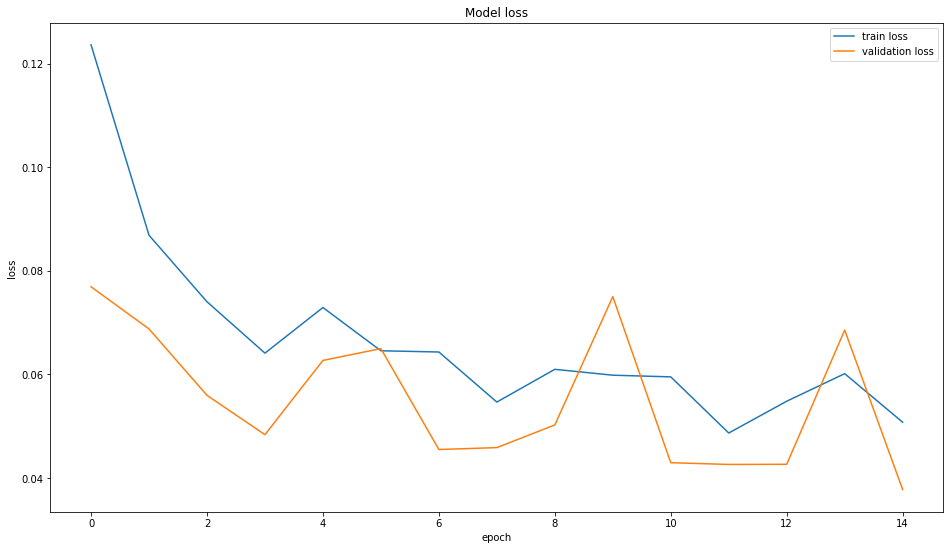

In [23]:
plt.figure(figsize=(16,9))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'])
plt.show()

In [24]:
data.columns

Index(['holiday', 'temp', 'rain_1h', 'snow_1h', 'clouds_all', 'weather_main',
       'weather_description', 'traffic_volume'],
      dtype='object')

In [25]:
  data_val = X_scaler.fit_transform(data[['holiday', 'temp', 'rain_1h', 'snow_1h', 'clouds_all', 'weather_main',
       'weather_description', 'traffic_volume']].tail(48))
  val_rescaled = data_val.reshape(1, data_val.shape[0], data_val.shape[1])

In [26]:
pred = lstm_model.predict(val_rescaled)
pred

array([[0.7151295 , 0.66047907, 0.6770988 , 0.67277825, 0.59726065,
        0.59229183, 0.5317829 , 0.4842304 , 0.4319589 , 0.33747435]],
      dtype=float32)

In [27]:
pred_Inverse = Y_scaler.inverse_transform(pred)

In [28]:
pred_Inverse

array([[5206.1426, 4808.2876, 4929.2793, 4897.8257, 4348.0576, 4311.885 ,
        3871.3796, 3525.1973, 3144.661 , 2456.8132]], dtype=float32)

In [29]:
def timeseries_evaluation_metrics_func(y_true, y_pred):
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [30]:
pred_Inverse[0]

array([5206.1426, 4808.2876, 4929.2793, 4897.8257, 4348.0576, 4311.885 ,
       3871.3796, 3525.1973, 3144.661 , 2456.8132], dtype=float32)

In [31]:
timeseries_evaluation_metrics_func(validate['traffic_volume'],pred_Inverse[0])

Evaluation metric results:-
MSE is : 1061416.456192702
MAE is : 927.4528564453125
RMSE is : 1030.2506763854622
MAPE is : 46.566718668095156
R2 is : 0.3109124602691249



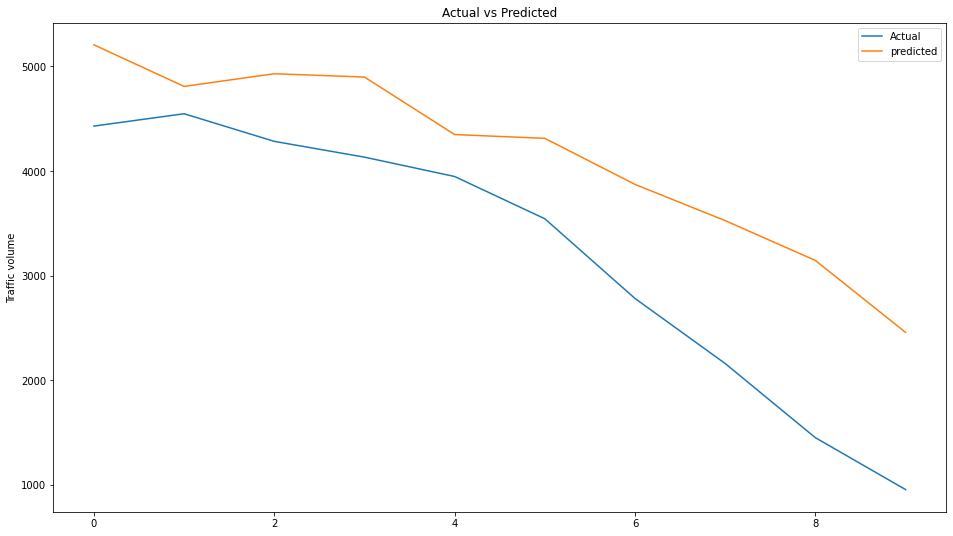

In [32]:
plt.figure(figsize=(16,9))
plt.plot( list(validate['traffic_volume']))
plt.plot( list(pred_Inverse[0]))
plt.title("Actual vs Predicted")
plt.ylabel("Traffic volume")
plt.legend(('Actual','predicted'))
plt.show()